In [1]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
df = pd.DataFrame()
for dataset in ["MIS", "CA","MVC"]:
    ml_training_path = Path(f"../wkdir/{dataset}/ml_training")
    for method_path in ml_training_path.iterdir():
        df_temp = pd.read_csv(method_path/"training_log.csv")
        df_temp["method"] = method_path.name
        df_temp["dataset"] = dataset
        df = pd.concat([df, df_temp], ignore_index=True)

In [3]:
df["Bipartite Graph"] = df["method"].apply(lambda x: x.split("_")[2])
df["Depth"] = df["method"].apply(lambda x: x.split("_")[3])
df["Layer"] = df["method"].apply(lambda x: x.split("_")[4])

In [4]:
# foreach method, get the best epoch
df_validation = df[df["partition"]=="valid"]
df_best_epoch = df_validation.loc[df_validation.groupby(["method","dataset"])["loss"].idxmin()]
#print(df_best_epoch[["Depth","Layer", "Bipartite Graph", "loss","f1_score_micro"]].sort_values("loss", ascending=True).reset_index(drop=True).to_latex(index=False, float_format="%.4f"))

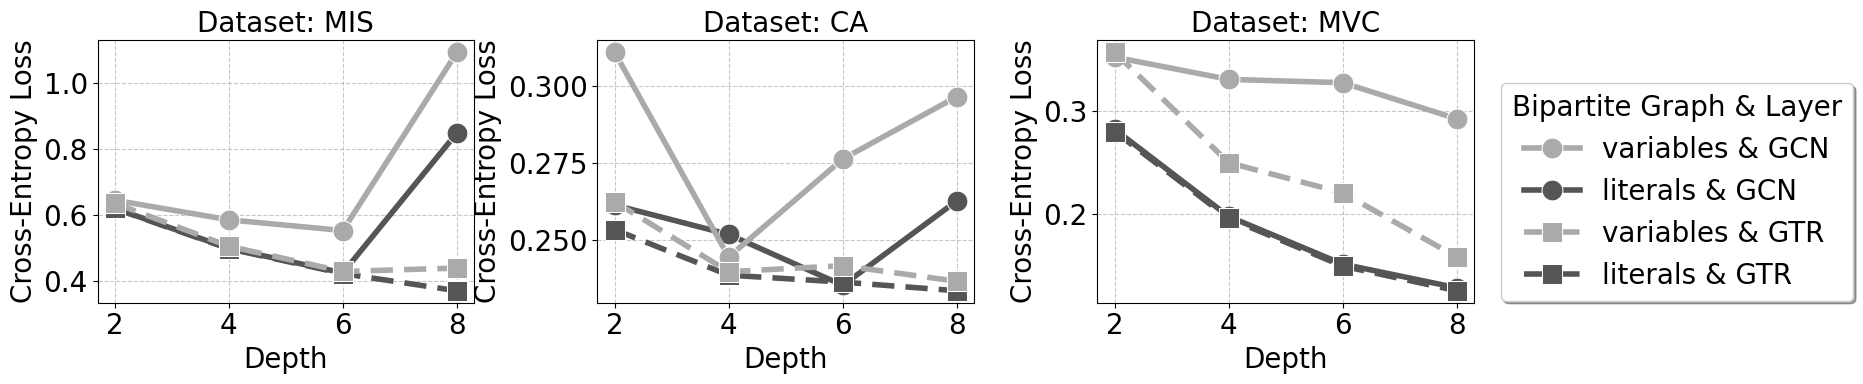

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create combined column for unique lines
df_best_epoch["series"] = df_best_epoch["Bipartite Graph"] + " & " + df_best_epoch["Layer"]

# Filter data for each dataset
df_mis_conpas = df_best_epoch[df_best_epoch["dataset"] == "MIS"]
df_ca_conpas = df_best_epoch[df_best_epoch["dataset"] == "CA"]
df_mvc_conpas = df_best_epoch[df_best_epoch["dataset"] == "MVC"]

# Set a consistent font size for all text elements
plt.rcParams.update({'font.size': 12})

# Create a figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True, sharey=False)

# Create explicit style mappings so same bipartite graph has same color,
# and same layer has same marker/linestyle
bipartite_graphs = df_best_epoch["Bipartite Graph"].unique()
layers = df_best_epoch["Layer"].unique()

# Gray palette for bipartite graphs
palette = dict(zip(bipartite_graphs, sns.color_palette("gray", n_colors=len(bipartite_graphs))))

# Map the series back to its original hue and style parts
markers_map = {}
dashes_map = {}
for series in df_best_epoch["series"].unique():
    bg, layer = series.split(" & ")
    markers_map[series] = "o" if layer == layers[0] else "s"  # choose marker by layer
    dashes_map[series] = "" if layer == layers[0] else (4, 2)  # choose line style by layer
    palette[series] = palette[bg]  # keep the same color as bipartite graph

# Define common plotting parameters
plot_params = {
    "x": "Depth",
    "y": "loss",
    "hue": "series",
    "style": "series",
    "markers": markers_map,
    "dashes": dashes_map,
    "palette": palette,
    "linewidth": 4,
    "markersize": 15,
    "errorbar": None,
}

# --- Plot MIS ---
sns.lineplot(data=df_mis_conpas, ax=axes[0], **plot_params)
axes[0].set_title("Dataset: MIS", fontsize=20)
axes[0].set_ylabel("Cross-Entropy Loss", fontsize=20)
axes[0].set_xlabel("Depth", fontsize=20)
axes[0].set_xticks(df_best_epoch["Depth"].unique())
axes[0].tick_params(axis='x', labelsize=20)
axes[0].tick_params(axis='y', labelsize=20)
axes[0].grid(True, linestyle='--', alpha=0.7)
axes[0].legend().remove()

# --- Plot CA ---
sns.lineplot(data=df_ca_conpas, ax=axes[1], **plot_params)
axes[1].set_title("Dataset: CA", fontsize=20)
axes[1].set_ylabel("Cross-Entropy Loss", fontsize=20)
axes[1].set_xlabel("Depth", fontsize=20)
axes[1].set_xticks(df_best_epoch["Depth"].unique())
axes[1].tick_params(axis='x', labelsize=20)
axes[1].tick_params(axis='y', labelsize=20)
axes[1].grid(True, linestyle='--', alpha=0.7)
axes[1].legend().remove()

# --- Plot MVC ---
sns.lineplot(data=df_mvc_conpas, ax=axes[2], **plot_params)
axes[2].set_title("Dataset: MVC", fontsize=20)
axes[2].set_ylabel("Cross-Entropy Loss", fontsize=20)
axes[2].set_xlabel("Depth", fontsize=20)
axes[2].set_xticks(df_best_epoch["Depth"].unique())
axes[2].tick_params(axis='x', labelsize=20)
axes[2].tick_params(axis='y', labelsize=20)
axes[2].grid(True, linestyle='--', alpha=0.7)
axes[2].legend().remove()

# --- Combined legend ---
handles, labels = axes[0].get_legend_handles_labels()

# Define desired order
desired_order = [
    "variables & GCN",
    "literals & GCN",
    "variables & GTR",
    "literals & GTR",
]

# Create a dictionary from labels to handles
label_handle_map = dict(zip(labels, handles))

# Sort handles and labels according to the desired order
sorted_labels = [label for label in desired_order if label in label_handle_map]
sorted_handles = [label_handle_map[label] for label in sorted_labels]

# Add the sorted legend to the figure
fig.legend(
    sorted_handles, sorted_labels,
    title="Bipartite Graph & Layer",
    title_fontsize=20,
    loc='center right',
    ncol=1,
    bbox_to_anchor=(1.25, 0.5),
    fancybox=True, shadow=True,
    fontsize=20
)

plt.tight_layout()
plt.savefig("compare_training_depth_loss.pdf", bbox_inches='tight')
plt.show()
